# Intro

In this set of notebooks, I am using the [Titanic dataset](https://www.kaggle.com/c/titanic) to explore ML model-building in Python with scikit-learn.

The Titanic dataset provides demographic and other information on passengers of the Titanic. The task is to predict the survival of a hold-out test set. 

In this notebook, I explore and clean the data and use it to generate new features used
to build up models in the 'Models.ipynb' notebook.

My approach is inspired by a number of public notebooks on this challenge, notably [this one](https://www.kaggle.com/pedrodematos/titanic-a-complete-approach-to-top-rankings)

# Load packages

In [2]:
# Data manipulation
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Automated EDA
import pandas_profiling
from autoviz.AutoViz_Class import AutoViz_Class
import ppscore as pps  # model-based feature interaction metric 

# Load and explore data

First, we load in the two datasests. "train.csv" contains the target column ("Survival"), while "test.csv" does not. 

In [3]:
train = pd.read_csv('data/train.csv').set_index('PassengerId')
sub = pd.read_csv('data/test.csv').set_index('PassengerId')

I'm combining the two datasets into one for the purpose of exploratory data analysis, to better understand the relationships between variables. 

In [4]:
df = pd.concat([train, sub])
tr = ~df['Survived'].isnull()  # create boolean mask for easy access of training data
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Right away, let's check and see if we have any missing values:

In [5]:
# Prints the percent missing from each column
(100*df.isnull().sum() / df.shape[0]).round(1)

Survived    31.9
Pclass       0.0
Name         0.0
Sex          0.0
Age         20.1
SibSp        0.0
Parch        0.0
Ticket       0.0
Fare         0.1
Cabin       77.5
Embarked     0.2
dtype: float64

We will need to come up with a strategy to impute values for Age, Fare and Embarked. 

The "Cabin" column is missing so many values that it might be useful as a boolean indicator feature. Let's check:

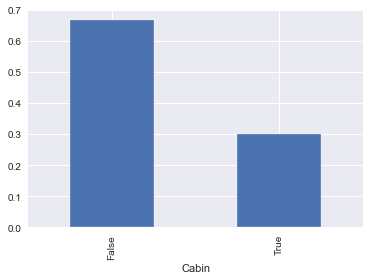

In [6]:
df[tr].groupby(df[tr]['Cabin'].isnull())['Survived'].mean().plot(kind='bar');

Correct! Only ~30% of passengers with missing Cabin data survived, while ~65% of passengers with Cabin data did. This can be used in classification later on

Now, we use automated EDA packages to get a better understanding of our data. 

In [7]:
report = pandas_profiling.ProfileReport(df)
report

Shape of your Data Set: (891, 12)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  3
    Number of String-Categorical Columns =  1
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  1
    Number of Discrete String Columns =  3
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    12 Predictors classified...
        This does not include the Target column(s)
        4 variables removed since they were ID or low-information variables
Number of All Scatter Plots = 3


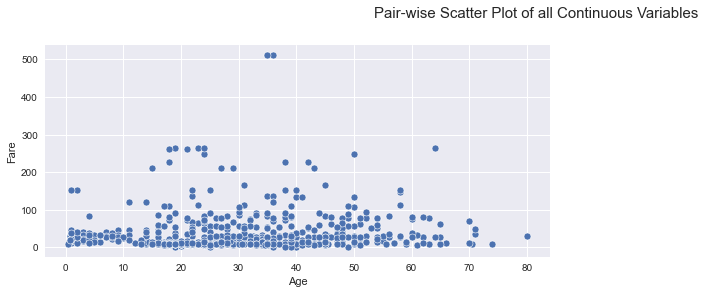

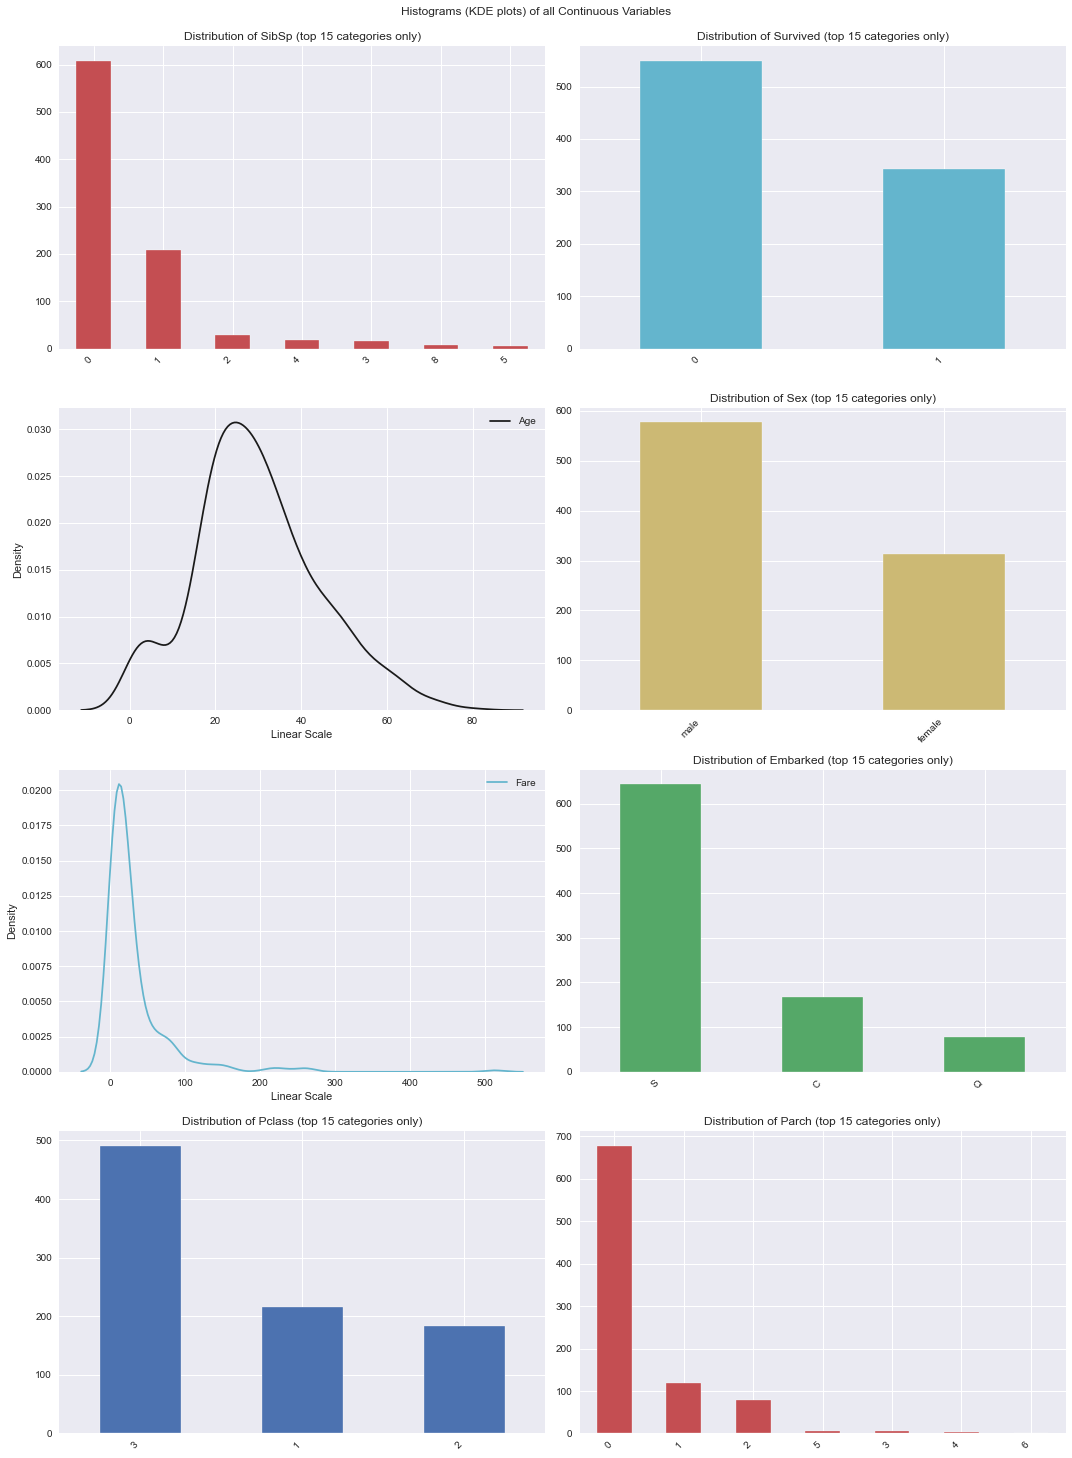

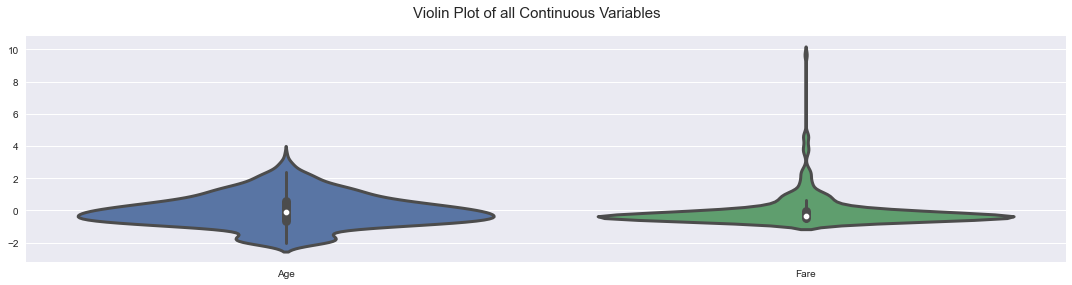

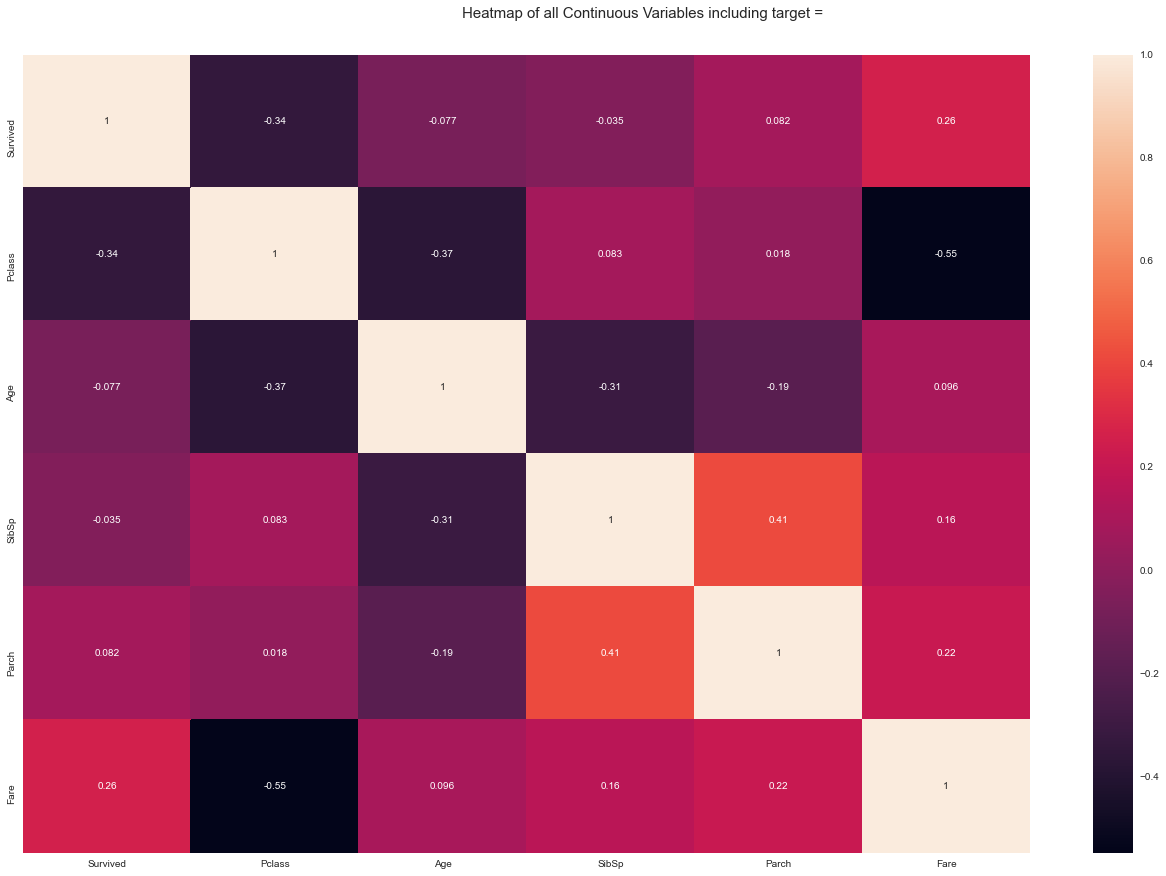

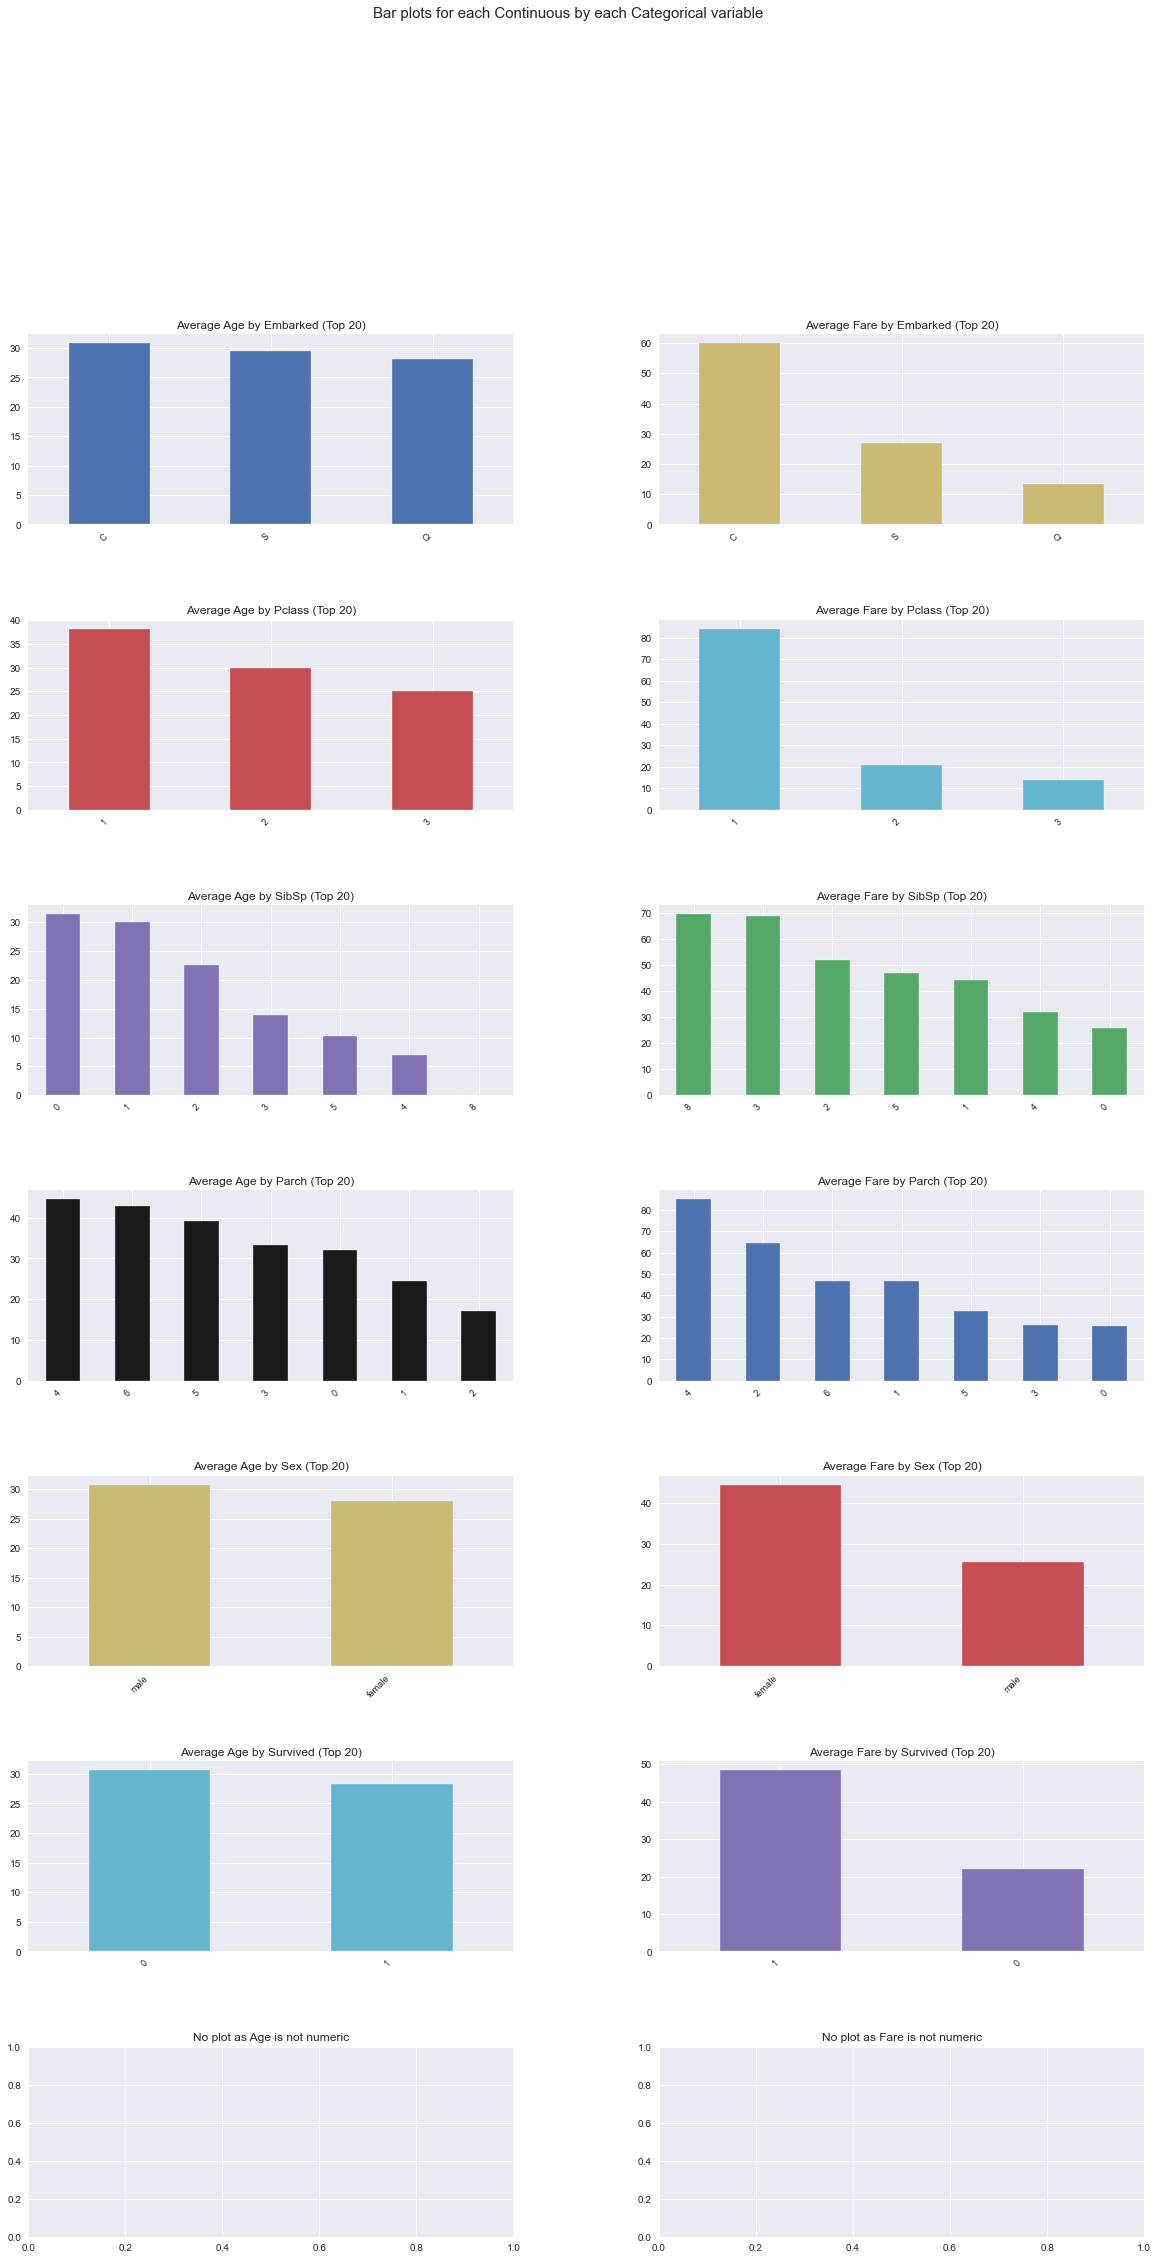

Time to run AutoViz (in seconds) = 4.480

 ###################### VISUALIZATION Completed ########################


In [8]:
AV = AutoViz_Class()
report2 = AV.AutoViz('./data/train.csv')

These profilers missed a few interactions of Survived with some categorical variables, plotting those here:

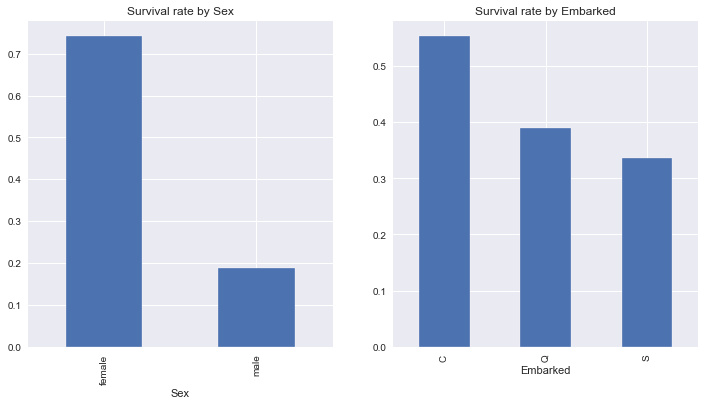

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

df[tr].groupby(['Sex'])['Survived'].mean().plot(kind='bar',ax=ax[0])
ax[0].set_title('Survival rate by Sex')

df[tr].groupby(['Embarked'])['Survived'].mean().plot(kind='bar',ax=ax[1])
ax[1].set_title('Survival rate by Embarked');

Summarizing insights for each column:

* Survived
    * Slightly unbalanced with more people who died than survived, we'll make sure to preserve class balances across CV folds later
    * Highly correlated with Sex, ~75% of females survived, whereas only <20% of males did
    * Also correlated with PClass, Fare and Embarked
* Name
    * Extremely high cardinality, but contains information on title ("Mr.", "Mrs.", etc) that can be useful
* Pclass
    * Highly correlated with Fare
    * Also correlated with Age
* Sex
    * Correlated with Fare
* Age
    * Roughly normally distributed
    * Contains missing data
    * Correlated with SibSp
* Fare
    * Skewed distribution, we might want to transform it 
* SibSp/Parch
    * Correlated with each other 
* Ticket
    * Very high cardinality, but does contain some shared values. It could be useful to create a column containing the overall frequency of each ticket number

# Feature creation

Here, we take the insights from our EDA to further process the data and create new features. 

Note that I am choosing to do processing on the entire concatenated dataframe, not just the training set. This might constitute data leakage in terms of imputation of missing values, however, I believe it is safe to assume the training and test sets are sampled from the same distributions, so this shouldn't affect generalization. In fact, for the purposes of this classification task, it might be safe to say that the training and test sets comprise the entire population.

New Title feature extracted from the Name column.

In [10]:
# Extract title 
df['Title'] = df['Name'].apply(lambda x : x.split(',')[1].split('.')[0].strip())

# Discretizing titles: female
df['Title'].replace(['Miss','Ms','Mlle'],'Ms',inplace=True)

# Status-related
df['Title'].replace(['Dona','Lady','Mme','the Countess','Master',
                     'Don','Rev','Dr','Capt','Major','Sir','Col','Jonkheer'],
                    'Sir/Lady',inplace=True)
df['Title'] = df['Title']

Here creating a column for FamilySurvival. The resulting values are as follows:
- 1 : someone in the passenger's family is known to have survived
- 0 : no one in the passenger's family is known to have survived, and at least 1 is known to have died
- 0.5 : no information on family survival

In [11]:
# Total family size 
familysize = (df['SibSp'] + df['Parch']).astype(int)

# Extract surname
df['Surname'] = df['Name'].apply(lambda x : x.split(',')[0])

# Default is 0.5
df['FamilySurvival'] = 0.5

# Selecting passengers with same Surname and Fare
for surname, sur_group in df[familysize > 0].groupby(['Surname','Fare']):
    for ind, row in sur_group.iterrows():
        smax = sur_group.drop(ind).Survived.max()
        smin = sur_group.drop(ind).Survived.min()
        passID = row.name
        # 1 if anyone in Family known to have survived
        if smax == 1:
            df.loc[df.index == passID, 'FamilySurvival'] = 1
        # 0 if no one in Family known to have survived and at least 1 known to have died
        elif smin == 0:
            df.loc[df.index == passID, 'FamilySurvival'] = 0  

The first letter of the Cabin number corresponds to different parts of the ship that might be correlated with survival. We also saw that missing Cabin numbers were highly correlated with survival, so we'll label those "X"

In [12]:
df['CabinLetter'] = [i[0] if not pd.isnull(i) else 'X' for i in df['Cabin']]

Extract ticket counts. This captures passengers traveling together who might not be family. 

In [13]:
# Number of passengers with same ticket
df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')

Now, we drop unused high-cardinality features and focus on imputing missing values. 

Values are missing from Age, Fare and Embarked. I am opting to use a KNN imputing strategy, to fill in missing data with the mean of the 5 nearest neighbors. Since this imputer assumes numerical data, the strategy is:

1. Label-encode Embarked (contains a missing value we want to estimate numerically)
2. One-hot encode all other categorical columns
3. Impute Age, Fare and Embarked
4. One-hot code Embarked

In [14]:
# Drop high-cardinality features
df.drop(['Name','Ticket','Surname','Cabin'],1,inplace=True)

# Label embarked for numerically imputing later
df['Embarked'] = df['Embarked'].astype('category').cat.codes
df.loc[df['Embarked'] == -1,'Embarked'] = np.nan  # relabel as missing

# One-hot encode rest of categorical 
cat_columns = ['Sex', 'Title', 'CabinLetter','FamilySurvival']
df = pd.get_dummies(df,columns=cat_columns)

# Impute Age, Fare and Embarked (making sure not to impute Survived!)
df[df.columns.difference(['Survived'])] = KNNImputer().fit_transform(df[df.columns.difference(['Survived'])])

# KNN uses mean, round new Embarked value to integer, then one-hot encode embarked
df['Embarked'] = df['Embarked'].apply(lambda x : round(x))
df = pd.get_dummies(df,columns=['Embarked'])

Fare is heavily skewed, so we quantize it into 13 equally-sized bins 

In [15]:
# Quantize Fare in to 13-iles
df['FareBin'] = pd.qcut(df['Fare'],13,labels=False)
df.drop(['Fare'],1,inplace=True)

# Look at final features

The [Predictive power score](https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598) is a useful metric of determining interactions between variables. In essence, it trains a univariate decision-tree for every feature-target pair and compares its performance to a baseline classifier, giving an asymmetric report of the relatedness of all variables. 

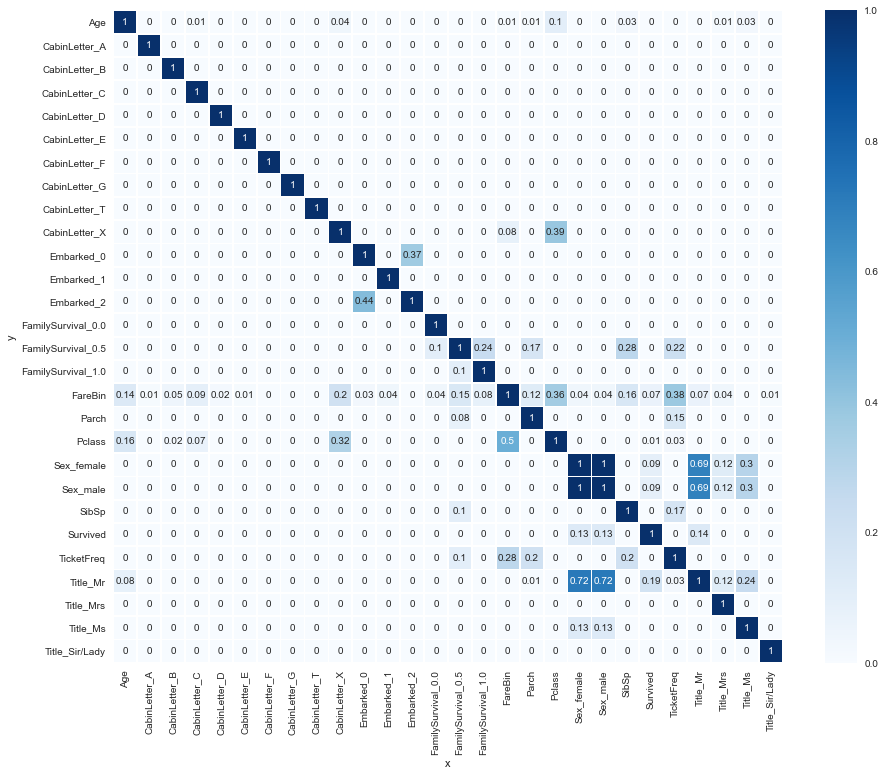

In [16]:
plt.figure(figsize=(15,12))

matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
matrix_df = matrix_df.apply(lambda x: round(x, 2))

sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.75, annot=True);

We have totally redundant information in the Sex_female and Sex_male columns, so we drop Sex_male. There is also a strong interaction between Title_Mr and Sex_female, so we drop Title_Mr, as it is effectively represented by the other Title columns

In [17]:
df.drop(['Sex_male','Title_Mr'],1,inplace=True)

We are now ready to save our full dataset and use it to build models in 'Models.ipynb'

In [18]:
df.to_csv('./data/df_full.csv')